In [76]:
import numpy as np
import pandas as pd

In [77]:
#Load Dataset
temp = np.load('QG_jets.npz')

In [78]:
print(temp.files)

['X', 'y']


In [79]:
print(len(temp["X"]))

100000


In [80]:
print((temp["y"]))

[1. 1. 1. ... 1. 0. 0.]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DE14CEA5F8>]],
      dtype=object)

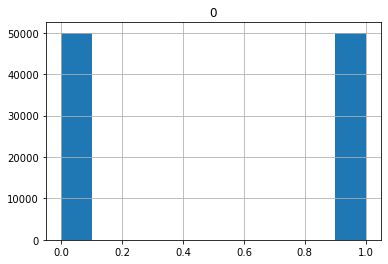

In [81]:
y=pd.DataFrame(temp["y"])

y.hist()

In [82]:
X=[]
for i in temp["X"]:
    X.append(i[0])
X=pd.DataFrame(X,columns=["pt","eta","azimuthal","pgdid"])
y=pd.DataFrame(temp["y"],columns=["Y"])
X["y"]=y
#X=X.sample(frac=0.5, replace=False, random_state=1)

In [83]:
X.head(10)
#print(len(X))

,pt,eta,azimuthal,pgdid,y
0,0.268769,0.356903,4.741387,22.0,1.0
1,1.212663,-0.112853,3.047088,-211.0,1.0
2,0.216829,-0.997057,0.532569,22.0,1.0
3,0.413806,0.956889,5.742566,211.0,1.0
4,0.476434,-0.403307,4.126747,22.0,1.0
5,7.702450,-0.819775,5.794888,321.0,0.0
6,0.235739,-1.094473,5.626174,211.0,1.0
7,0.317746,0.245092,1.284100,211.0,1.0
8,0.879651,0.109774,3.468267,211.0,1.0
9,0.160245,-1.455975,3.670505,22.0,1.0


In [84]:
X=X[:50000]

In [85]:
y=X["y"]
X=X.drop(["y"],axis=1)

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [87]:
print(len(X_train))

35000


## DGL

In [88]:
import dgl
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import networkx as nx

In [89]:
def build_karate_club_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(len(X))
    src, dst = tuple(zip(*edges))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bidirectional
    g.add_edges(dst, src)
    return g

In [90]:
from itertools import combinations  
edge_list=combinations(range(int(len(X_train)/100)),2)

In [91]:
edge_list=list(edge_list)

In [114]:
print(len(edge_list))

61075


In [93]:
G = build_karate_club_graph(edge_list)

In [94]:
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 50000 nodes.
We have 122150 edges.


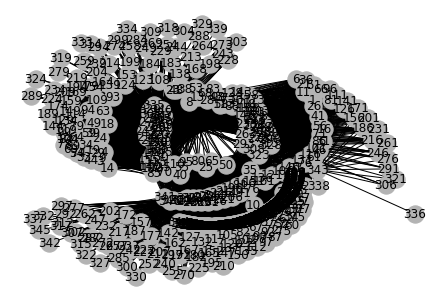

In [121]:
def draw_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(len(X)/100)
    src, dst = tuple(zip(*edges))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bidirectional
    g.add_edges(dst, src)
    return g
D=draw_graph(edge_list[::15])
# Since the actual graph is undirected, we convert it for visualization purpose.
nx_G = D.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [95]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message and reduce function
# NOTE: We ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [106]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        h = self.softmax(h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(4, 10, 2)

In [107]:
inputs = torch.tensor(X.values)#torch.eye(node_count)
labeled_nodes = torch.tensor(y_train[::3].index)#torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor(y_train[::3].values)  # their labels are different

In [108]:
print(max(y_train[::3].keys()),len(labels))

49997 11667


In [109]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
all_preds = []
epochs = 30

for epoch in range(epochs):
    preds = net(G, inputs.float())
    all_preds.append(preds)
    # we only compute loss for labeled nodes
    print(len(preds),len(labels))
    loss = F.cross_entropy(preds[labeled_nodes], labels.long())

    optimizer.zero_grad() # PyTorch accumulates gradients by default
    loss.backward() 
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

c:\users\mstal\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


50000 11667
Epoch 0 | Loss: 0.6971
50000 11667
Epoch 1 | Loss: 0.6947
50000 11667
Epoch 2 | Loss: 0.6947
50000 11667
Epoch 3 | Loss: 0.6954
50000 11667
Epoch 4 | Loss: 0.6955
50000 11667
Epoch 5 | Loss: 0.6951
50000 11667
Epoch 6 | Loss: 0.6947
50000 11667
Epoch 7 | Loss: 0.6944
50000 11667
Epoch 8 | Loss: 0.6946
50000 11667
Epoch 9 | Loss: 0.6948
50000 11667
Epoch 10 | Loss: 0.6949
50000 11667
Epoch 11 | Loss: 0.6948
50000 11667
Epoch 12 | Loss: 0.6947
50000 11667
Epoch 13 | Loss: 0.6944
50000 11667
Epoch 14 | Loss: 0.6944
50000 11667
Epoch 15 | Loss: 0.6946
50000 11667
Epoch 16 | Loss: 0.6947
50000 11667
Epoch 17 | Loss: 0.6947
50000 11667
Epoch 18 | Loss: 0.6947
50000 11667
Epoch 19 | Loss: 0.6946
50000 11667
Epoch 20 | Loss: 0.6944
50000 11667
Epoch 21 | Loss: 0.6945
50000 11667
Epoch 22 | Loss: 0.6945
50000 11667
Epoch 23 | Loss: 0.6945
50000 11667
Epoch 24 | Loss: 0.6946
50000 11667
Epoch 25 | Loss: 0.6945
50000 11667
Epoch 26 | Loss: 0.6944
50000 11667
Epoch 27 | Loss: 0.6945
50

In [122]:
last_epoch = all_preds[epochs-1].detach().numpy()
predicted_class = np.argmax(last_epoch, axis=-1)
color = np.where(predicted_class==0, 'g', 'p')

print(predicted_class)
print(color)

[0 0 0 ... 1 1 1]
['g' 'g' 'g' ... 'p' 'p' 'p']


## PyTorch

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import SplineConv

dataset = 'Cora'
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.TargetIndegree())
data = dataset[0]

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:data.num_nodes - 1000] = 1
data.val_mask = None
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[data.num_nodes - 500:] = 1


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SplineConv(dataset.num_features, 16, dim=1, kernel_size=2)
        self.conv2 = SplineConv(16, dataset.num_classes, dim=1, kernel_size=2)

    def forward(self):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.dropout(x, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


for epoch in range(1, 201):
    train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, *test()))

In [123]:
# Too complex to be drawn
#nx.draw_networkx(nx_G, pos, node_color=color, with_labels=True, node_size=300)